# HealthPulse — Notebook 02: EDA

## Goal
Quickly explore the cleaned modeling dataset to understand:
- Target imbalance (no-show rate)
- Which features show the strongest signal (lead time, time, specialty, clinic)
- Data quality (missingness, duplicates, weird values)
- What to prioritize for modeling

## Output of this notebook
- Sset of EDA tables + plots that tell a clear story
- A shortlist of top predictive features + potential interactions
- Notes on modeling decisions (metrics, class imbalance handling, leakage checks)

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

#### Load Dataset

In [3]:
# CSV
df = pd.read_csv("../data/processed/appointments_modeling_base.csv")

df.shape

(120000, 26)

In [4]:
df.head()

,clinic_id,date_id_x,appointment_time,appointment_date,lead_time_days,is_no_show,insurance_type,age,specialty,clinic_assignment_x,clinic_assignment_y,clinic_name,city,hours,date_id_y,day_of_week,month_name,year,appt_hour,appt_minute,prev_appointments,prev_no_shows,hist_no_show_rate,is_first_appointment,has_prev_no_show,last_no_show
0,C013,27499,2026-02-23 12:15:00,2023-01-19,2,0,Private,63,Ophthalmology,Full-time,Full-time,Ophthalmology Clinic,Houston,08:00-18:00,671,Thu,Jan,2023,12,15,0,0.0,0.0,1,0,0.0
1,C014,100779,2026-02-23 14:30:00,2023-01-20,0,0,Private,63,Obstetrics & Gynecology,Full-time,Full-time,Women's Health Clinic,Atlanta,08:00-16:00,838,Fri,Jan,2023,14,30,1,0.0,0.0,0,0,0.0
2,C004,109546,2026-02-23 18:15:00,2023-04-17,9,0,Private,63,Dentistry,Full-time,Full-time,Dental Clinic,New York,10:00-19:00,608,Mon,Apr,2023,18,15,2,0.0,0.0,0,0,0.0
3,C013,87232,2026-02-23 07:00:00,2023-05-06,15,0,Private,63,Ophthalmology,Full-time,Full-time,Ophthalmology Clinic,Houston,08:00-18:00,585,Sat,May,2023,7,0,3,0.0,0.0,0,0,0.0
4,C003,2977,2026-02-23 18:45:00,2023-05-08,8,0,Private,63,Orthopedics,Full-time,Full-time,Orthopedic Clinic,Houston,09:00-17:00,1322,Mon,May,2023,18,45,4,0.0,0.0,0,0,0.0


In [5]:
df.info()
df.describe(include="all").T.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   clinic_id             120000 non-null  object 
 1   date_id_x             120000 non-null  int64  
 2   appointment_time      120000 non-null  object 
 3   appointment_date      120000 non-null  object 
 4   lead_time_days        120000 non-null  int64  
 5   is_no_show            120000 non-null  int64  
 6   insurance_type        120000 non-null  object 
 7   age                   120000 non-null  int64  
 8   specialty             120000 non-null  object 
 9   clinic_assignment_x   120000 non-null  object 
 10  clinic_assignment_y   120000 non-null  object 
 11  clinic_name           120000 non-null  object 
 12  city                  120000 non-null  object 
 13  hours                 120000 non-null  object 
 14  date_id_y             120000 non-null  int64  
 15  

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
clinic_id,120000,15,C003,14254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_id_x,120000.0,NaN,NaN,NaN,70673.0952,39702.280036,1.0,35172.75,68788.5,106020.25,136020.0
appointment_time,120000,49,2026-02-23 17:15:00,2552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appointment_date,120000,1096,2023-09-24,147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_time_days,120000.0,NaN,NaN,NaN,13.9728,9.288269,0.0,7.0,14.0,20.0,63.0
is_no_show,120000.0,NaN,NaN,NaN,0.177867,0.382402,0.0,0.0,0.0,0.0,1.0
insurance_type,120000,3,Private,64914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,120000.0,NaN,NaN,NaN,42.710733,23.41061,0.0,24.0,43.0,60.0,90.0
specialty,120000,15,Orthopedics,14254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clinic_assignment_x,120000,3,Full-time,80273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
missing = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing[missing > 0].head(30)

Series([], dtype: float64)

In [7]:
dup_rows = df.duplicated().sum()
print("Duplicate rows:", dup_rows)

Duplicate rows: 0


#### Target distribution

In [8]:
target = "is_no_show"

counts = df[target].value_counts()
rates = df[target].value_counts(normalize=True).round(4)

print("Counts:\n", counts)
print("\nRates:\n", rates)

baseline_acc = float(rates.get(0, 0))
print("\nBaseline accuracy if always predict SHOW (0):", baseline_acc)

Counts:
 is_no_show
0    98656
1    21344
Name: count, dtype: int64

Rates:
 is_no_show
0    0.8221
1    0.1779
Name: proportion, dtype: float64

Baseline accuracy if always predict SHOW (0): 0.8221


In [9]:
def no_show_rate_by(col, top=20, ascending=False):
    if col not in df.columns:
        print(f"Missing column: {col}")
        return None
    out = df.groupby(col)[target].mean().sort_values(ascending=ascending)
    return out.head(top) if ascending is False else out.tail(top)

In [10]:
display(no_show_rate_by("day_of_week", top=10))
display(no_show_rate_by("month_name", top=12))
display(no_show_rate_by("insurance_type", top=10))
display(no_show_rate_by("specialty", top=20))
display(no_show_rate_by("clinic_name", top=20))
display(no_show_rate_by("city", top=20))

day_of_week
Wed    0.181091
Thu    0.180692
Fri    0.180143
Tue    0.177448
Sun    0.177389
Sat    0.176053
Mon    0.172356
Name: is_no_show, dtype: float64

month_name
Jul    0.183439
Oct    0.182643
Sep    0.178884
Apr    0.178477
Mar    0.177153
Jun    0.177092
Nov    0.176943
Aug    0.176710
Jan    0.176412
Dec    0.176400
Feb    0.175379
May    0.174561
Name: is_no_show, dtype: float64

insurance_type
Public      0.178255
Private     0.177727
Self-pay    0.177266
Name: is_no_show, dtype: float64

specialty
Dentistry                  0.186347
Orthopedics                0.181353
Obstetrics & Gynecology    0.181256
Gastroenterology           0.180993
Urology                    0.178213
Psychiatry                 0.178108
Ophthalmology              0.177879
Dermatology                0.176534
Cardiology                 0.176274
Otolaryngology             0.175547
Pulmonology                0.174128
Neurology                  0.174052
Oncology                   0.172820
Endocrinology              0.170374
Family Medicine            0.168917
Name: is_no_show, dtype: float64

clinic_name
Dental Clinic              0.186347
Orthopedic Clinic          0.181353
Women's Health Clinic      0.181256
Gastroenterology Clinic    0.180993
Urology Clinic             0.178213
Psychiatry Clinic          0.178108
Ophthalmology Clinic       0.177879
Dermatology Clinic         0.176534
Cardiology Clinic          0.176274
ENT Clinic                 0.175547
Pulmonology Clinic         0.174128
Neurology Clinic           0.174052
Oncology Clinic            0.172820
Endocrinology Clinic       0.170374
Primary Care Clinic        0.168917
Name: is_no_show, dtype: float64

city
New York       0.179720
Houston        0.178077
Atlanta        0.178012
Chicago        0.176659
Los Angeles    0.176274
Name: is_no_show, dtype: float64

#### Lead time analysis

C:\Users\icons\AppData\Local\Temp\ipykernel_9340\1940456036.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_bin_rate = df.groupby("lead_time_bin")[target].mean()


lead_time_bin
(-0.001, 5.0]    0.075680
(5.0, 11.0]      0.136825
(11.0, 16.0]     0.179317
(16.0, 22.0]     0.219037
(22.0, 63.0]     0.294310
Name: is_no_show, dtype: float64

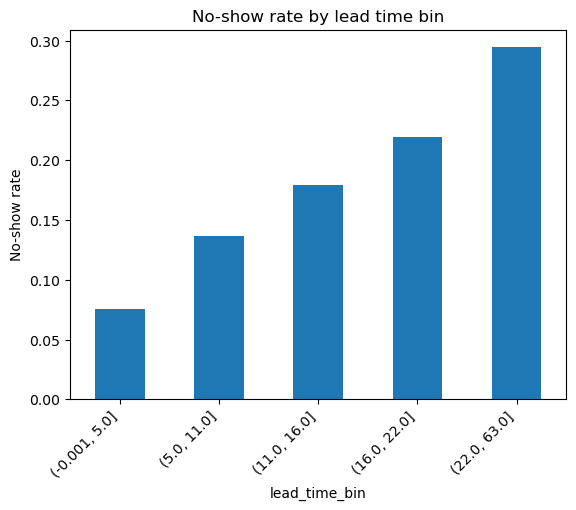

In [11]:
# Bin lead_time_days into quantiles
df["lead_time_bin"] = pd.qcut(df["lead_time_days"], q=5, duplicates="drop")

lead_bin_rate = df.groupby("lead_time_bin")[target].mean()
display(lead_bin_rate)

# Plot
lead_bin_rate.plot(kind="bar")
plt.ylabel("No-show rate")
plt.title("No-show rate by lead time bin")
plt.xticks(rotation=45, ha="right")
plt.show()

#### Appointment hour analysis

appt_hour
7     0.179998
8     0.178403
9     0.181677
10    0.180335
11    0.171180
12    0.182937
13    0.175909
14    0.180295
15    0.181463
16    0.178118
17    0.167071
18    0.180147
19    0.166191
Name: is_no_show, dtype: float64

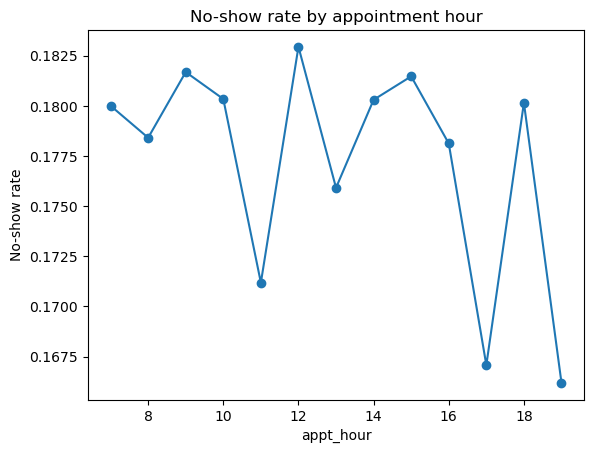

In [12]:
if "appt_hour" in df.columns:
    hour_rate = df.groupby("appt_hour")[target].mean()
    display(hour_rate)

    hour_rate.plot(kind="line", marker="o")
    plt.ylabel("No-show rate")
    plt.title("No-show rate by appointment hour")
    plt.show()
else:
    print("appt_hour not found. Did you create it in Notebook 01?")

#### Correlation check for numeric features

In [14]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]

corr = df[[target] + num_cols].corr(numeric_only=True)[target].sort_values(ascending=False)
display(corr)

is_no_show              1.000000
lead_time_days          0.200574
prev_no_shows           0.010766
date_id_y               0.007166
hist_no_show_rate       0.006468
has_prev_no_show        0.005793
is_first_appointment    0.003999
year                    0.001226
prev_appointments       0.000968
appt_minute            -0.000088
date_id_x              -0.001378
last_no_show           -0.002646
appt_hour              -0.004141
age                    -0.021063
Name: is_no_show, dtype: float64

In [15]:
if "specialty" in df.columns:
    pivot = df.pivot_table(
        values=target,
        index="specialty",
        columns="lead_time_bin",
        aggfunc="mean"
    )
    display(pivot.head(20))
else:
    print("specialty not found.")

C:\Users\icons\AppData\Local\Temp\ipykernel_9340\2509548921.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


lead_time_bin,"(-0.001, 5.0]","(5.0, 11.0]","(11.0, 16.0]","(16.0, 22.0]","(22.0, 63.0]"
specialty,,,,,
Cardiology,0.071139,0.131408,0.165073,0.235147,0.297987
Dentistry,0.080863,0.147429,0.185494,0.234578,0.300739
Dermatology,0.070588,0.134625,0.192771,0.215770,0.286483
Endocrinology,0.059211,0.155388,0.182266,0.210177,0.255000
Family Medicine,0.069307,0.120050,0.190094,0.197368,0.295107
Gastroenterology,0.075957,0.156702,0.174935,0.210079,0.297077
Neurology,0.082040,0.129787,0.174877,0.203620,0.290476
Obstetrics & Gynecology,0.089928,0.141827,0.158455,0.223667,0.315186
Oncology,0.066533,0.132747,0.177759,0.209746,0.293744


# 📊 EDA Interpretation — HealthPulse No-Show Analysis

## 1️⃣ Data Quality Summary

- Total rows: **120,000**
- No missing values detected
- No duplicate rows
- Dataset is clean and ready for modeling

Target distribution:
- Show (0): **82.21%**
- No-show (1): **17.79%**

Baseline accuracy (always predict SHOW): **82.21%**

⚠️ This confirms:
- The dataset is moderately imbalanced.
- Accuracy alone is misleading.
- Recall and precision for the no-show class (1) will be critical evaluation metrics.

---

## 2️⃣ Categorical Feature Insights

### Day of Week
- Range: ~17.2% – 18.1%
- Very small variation (~1%)
- Weak standalone predictor

### Month
- Range: ~17.4% – 18.3%
- Slight seasonal variation
- Weak to moderate effect

### Insurance Type
- Nearly identical across categories (~17.7–17.8%)
- Very weak predictor

### Specialty
- Range: ~16.9% – 18.6%
- Dentistry highest (~18.6%)
- Family Medicine lowest (~16.9%)
- Moderate signal

### Clinic & City
- Minor variation across locations
- Likely weak independent predictors
- May contribute interaction effects

---

## 3️⃣ Lead Time — Strongest Predictor Identified

Lead time shows a clear monotonic relationship:

| Lead Time (Days) | No-Show Rate |
|------------------|-------------|
| 0–5              | 7.6%        |
| 5–11             | 13.7%       |
| 11–16            | 17.9%       |
| 16–22            | 21.9%       |
| 22–63            | 29.4%       |

Key Insight:
- No-show probability increases dramatically as lead time increases.
- Patients scheduled far in advance are much more likely to no-show.
- Lead time is the most predictive feature identified so far.
- Correlation with target: **~0.20**, highest among numeric features.

This will likely dominate the model.

---

## 4️⃣ Appointment Hour

- Variation between ~16.6% – 18.3%
- Slight fluctuations across hours
- Moderate signal
- Could interact with specialty or clinic

---

## 5️⃣ Patient Behavioral Features

Numeric correlations with target:

| Feature | Correlation |
|----------|------------|
| lead_time_days | **0.2006** |
| prev_no_shows | 0.0107 |
| hist_no_show_rate | 0.0065 |
| has_prev_no_show | 0.0058 |
| is_first_appointment | 0.0040 |

Observation:
- Behavioral features show surprisingly weak correlation.
- Patient behavior appears relatively stable in this dataset.
- The dataset may not contain strong behavioral clustering.
- Recency effects (last_no_show) were minimal.

This suggests:
- Lead time is driving much of the predictive signal.
- Patient history may contribute marginal improvements.

---

## 6️⃣ Interaction Insight: Lead Time × Specialty

Across all specialties:
- Lead time increases consistently raise no-show probability.
- The monotonic trend persists regardless of specialty.
- Some specialties (e.g., Obstetrics & Gynecology, Psychiatry) reach >30% no-show rate at high lead times.

Conclusion:
- Lead time effect is universal across specialties.
- Specialty may amplify the lead time effect.

---

# 🎯 Final EDA Conclusions

### Strong Predictors
- Lead time (dominant signal)
- Specialty (moderate)
- Appointment hour (moderate)

### Weak Predictors
- Insurance type
- Day of week
- City
- Patient historical rate (in this dataset)

### Modeling Strategy Implications

- Lead time must be treated carefully (consider non-linear effects or binning).
- Threshold tuning will be important due to class imbalance.
- Recall optimization for no-show class is recommended.
- Gradient boosting models may capture interactions better than linear models.

---